By Ishwar Gautam 
(YouTube: <a href="https://www.youtube.com/channel/UC4Wf9XNPsbXwQqfKlUZfmtw">IG Tech Team</a>)

### 1. Collect the images

In [1]:
def screen_capture():
    import pyscreenshot as ImageGrab #pip install pyscreenshot
    import time

    images_folder = "captured_images/0/"
    #images_folder = "new_images/"

    for i in range(5):
        time.sleep(5)
        im = ImageGrab.grab(bbox=(60, 170, 400, 550)) # X1,Y1,X2,Y2
        print ("saved....",i)
        im.save(images_folder+str(i)+'.png')
        print ("clear screen now and redraw again...")
#screen_capture()

### 2. Create data with label

In [2]:
import numpy as np

def create_label(image_name):
    """ Create an one-hot encoded vector from image name """ 
    if image_name == '0':  
        return np.array([1,0,0,0,0,0,0,0,0,0])
    elif image_name == '1':
        return np.array([0,1,0,0,0,0,0,0,0,0])
    elif image_name == '2':
        return np.array([0,0,1,0,0,0,0,0,0,0])
    elif image_name == '3':
        return np.array([0,0,0,1,0,0,0,0,0,0])
    elif image_name == '4':
        return np.array([0,0,0,0,1,0,0,0,0,0])
    elif image_name == '5':
        return np.array([0,0,0,0,0,1,0,0,0,0])
    elif image_name == '6':
        return np.array([0,0,0,0,0,0,1,0,0,0])
    elif image_name == '7':
        return np.array([0,0,0,0,0,0,0,1,0,0])
    elif image_name == '8':
        return np.array([0,0,0,0,0,0,0,0,1,0])
    elif image_name == '9':
        return np.array([0,0,0,0,0,0,0,0,0,1])

In [3]:
import os
import cv2
from random import shuffle
from tqdm import tqdm

def create_data():
    data = []
    for folder in tqdm(os.listdir("captured_images")):
        for img in os.listdir("captured_images/"+folder):
            path = os.path.join("captured_images",folder, img)
            img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            try:
                img_data = cv2.resize(img_data, (28,28))
            except cv2.error as e:
                continue
            data.append([np.array(img_data), create_label(folder)])
    shuffle(data)
    return data

In [4]:
data = create_data()

100%|████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.67s/it]


### 3. Dividing data into training and testing part

In [5]:
train = data[:800]
test = data[800:]
X_train = np.array([i[0] for i in train]).reshape(-1, 28,28, 1)
y_train = [i[1] for i in train]
X_test = np.array([i[0] for i in test]).reshape(-1, 28,28, 1)
y_test = [i[1] for i in test]

### 4. Buiding the model

In [7]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [8]:
## Steps of Convolutional neural network:
# 1. Convolution layers
# 2. Normalization
# 3. Pooling
# 4. Fully connected

In [9]:
tf.reset_default_graph()
convnet = input_data(shape=[28,28, 1], name='input') 
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.5) #prevent a model from overfitting
convnet = fully_connected(convnet, 10, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy', name='targets')  
model = tflearn.DNN(convnet, tensorboard_verbose=1)  
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=12,
          validation_set=({'input': X_test}, {'targets': y_test}),
          show_metric=True)

Training Step: 155  | total loss: 0.02571 | time: 2.896s
| Adam | epoch: 012 | loss: 0.02571 - acc: 0.9929 -- iter: 768/800
Training Step: 156  | total loss: 0.02389 | time: 4.160s
| Adam | epoch: 012 | loss: 0.02389 - acc: 0.9936 | val_loss: 0.14367 - val_acc: 0.9750 -- iter: 800/800
--


### 5. Let's predict and display using matplotlib

In [12]:
def create_test_data():
    data = []
    for img in tqdm(os.listdir("new_images")):
        path = os.path.join("new_images", img)
        img_num = img.split('.')[0] 
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        try:
            img_data = cv2.resize(img_data, (28,28))
        except cv2.error as e:
            continue
        data.append([np.array(img_data), img_num])

    shuffle(data)
    return data

In [13]:
test_data = create_test_data()

100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.62it/s]


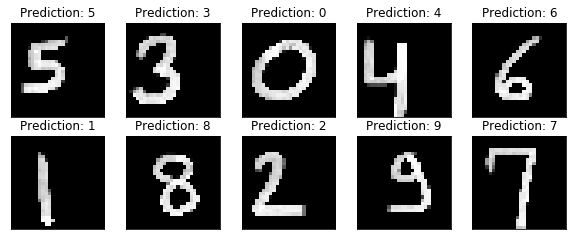

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
for num, data in enumerate(test_data[:10]):
    img_data = data[0]
    y = fig.add_subplot(5,5, num + 1)
    orig = img_data
    data = img_data.reshape(28,28, 1)
    model_out = model.predict([data])
    str_label = "Prediction: " + str(np.argmax(model_out))

    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()